In [1]:
# We import the packages along with other useful libraries.
%matplotlib inline
import astropy.units as u
import astropy.io.fits as fits
import numpy as np
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
import vip_hci as vip
from hciplot import plot_frames, plot_cubes
import pyds9 as sao

In [2]:
# We import all the routines that will be used in this code.
from packaging import version
vvip = vip.__version__
print("VIP version: ", vvip)
if version.parse(vvip) < version.parse("1.0.0"):
    msg = "Please upgrade your version of VIP"
    msg+= "It should be 1.0.0 or above to run this notebook."
    raise ValueError(msg)
elif version.parse(vvip) <= version.parse("1.0.3"):
    from vip_hci.conf import VLT_NACO
    from vip_hci.medsub import median_sub
    from vip_hci.metrics import normalize_psf
    from vip_hci.pca import pca, pca_annular
else:
    from vip_hci.config import VLT_NACO
    from vip_hci.fm import normalize_psf
    from vip_hci.psfsub import median_sub, pca, pca_annular

# common to all versions:
from vip_hci.fits import open_fits, write_fits, info_fits
from vip_hci.metrics import significance, snr, snrmap, contrast_curve, detection, throughput 
from vip_hci.var import fit_2dgaussian, frame_center
from vip_hci.preproc import (approx_stellar_position, cube_correct_nan, cube_crop_frames,
                             cube_detect_badfr_correlation, cube_fix_badpix_annuli,
                             cube_fix_badpix_clump, cube_fix_badpix_isolated,
                             cube_px_resampling, cube_recenter_2dfit, cube_recenter_dft_upsampling,
                             cube_recenter_satspots, cube_recenter_via_speckles, cube_shift,
                             frame_center_radon, frame_crop, frame_fix_badpix_isolated)

VIP version:  1.4.0


In [3]:
# Let's define the pixel scale for SPHERE (IRDIS)
mas = 12.25 * u.mas  #milliarcseconds
pxscale_sphere = mas.to(u.arcsec)/u.arcsec
pxscale_sphere

<Quantity 0.01225>

Pixel scale is a measurement of how much of the sky is covered by one pixel

## Loading and visualizing the data

In [4]:
# Now we load all the data in memory with the open_fits function
cubename = '/home/cvargas/sphere/IRDIS/HD143006/Target/HD-143006_DB_K12_2022-07-02_ird_convert_recenter_dc2021_star_hopping_478861/ird_convert_recenter_dc2021-IRD_SCIENCE_REDUCED_MASTER_CUBE-center_im.fits'
cube_refname = '/home/cvargas/sphere/IRDIS/HD143006/Reference/2MASS-J15593846-2227390_DB_K12_2022-07-02_ird_convert_recenter_dc2021_star_hopping_478862/ird_convert_recenter_dc2021-IRD_SCIENCE_REDUCED_MASTER_CUBE-center_im.fits'
psfname = '/home/cvargas/sphere/IRDIS/HD143006/Target/HD-143006_DB_K12_2022-07-02_ird_convert_recenter_dc2021_star_hopping_478861/ird_convert_recenter_dc2021-IRD_SCIENCE_PSF_MASTER_CUBE-median_unsat.fits'
anglename = '/home/cvargas/sphere/IRDIS/HD143006/Target/HD-143006_DB_K12_2022-07-02_ird_convert_recenter_dc2021_star_hopping_478861/ird_convert_recenter_dc2021-IRD_SCIENCE_PARA_ROTATION_CUBE-rotnth.fits'

cube = open_fits(cubename)
cube_ref = open_fits(cube_refname)
psf = open_fits(psfname)
angle = open_fits(anglename)

Fits HDU-0 data successfully loaded. Data shape: (2, 32, 1024, 1024)
Fits HDU-0 data successfully loaded. Data shape: (2, 16, 1024, 1024)
Fits HDU-0 data successfully loaded. Data shape: (2, 2, 64, 64)
Fits HDU-0 data successfully loaded. Data shape: (32,)


In [5]:
cubee = fits.open(cubename)

In [6]:
# Let's verify that the data corresponds to the reference star of GWLup
cuberef = fits.open('/home/cvargas/sphere/IRDIS/HD143006/Reference/2MASS-J15593846-2227390_DB_K12_2022-07-02_ird_convert_recenter_dc2021_star_hopping_478862/ird_convert_recenter_dc2021-IRD_SCIENCE_REDUCED_MASTER_CUBE-center_im.fits')
cuberef[0].header

SIMPLE  =                    T / Written by IDL:  Wed Aug 30 20:43:30 2023      
BITPIX  =                  -32 / IEEE single precision floating point           
NAXIS   =                    4 / number of data axes                            
NAXIS1  =                 1024 /Number of positions along axis 1                
NAXIS2  =                 1024 /Number of positions along axis 2                
NAXIS3  =                   16 /Number of positions along axis 3                
NAXIS4  =                    2 /Number of positions along axis 4                
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
DATE    = '2023-08-30T18:16:16' / file creation date (YYYY-MM-DDThh:mm:ss UT)   
ORIGIN  = 'ESO-PARANAL'        / European Southern Observatory                  
TELESCOP= 'ESO-VLT-U3'      

New shape: (2, 16, 100, 100)


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

:Dataset   [x,y,time,lambda]   (flux)
:Cube_shape	[100, 100, 16, 2]


:HoloMap   [time,lambda]
   :Image   [x,y]   (flux)
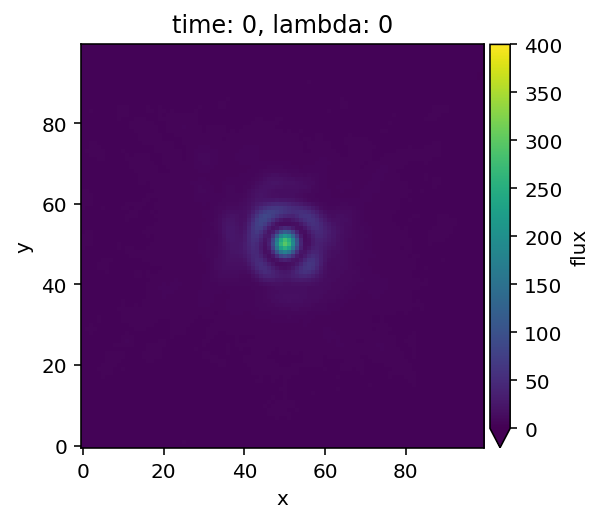
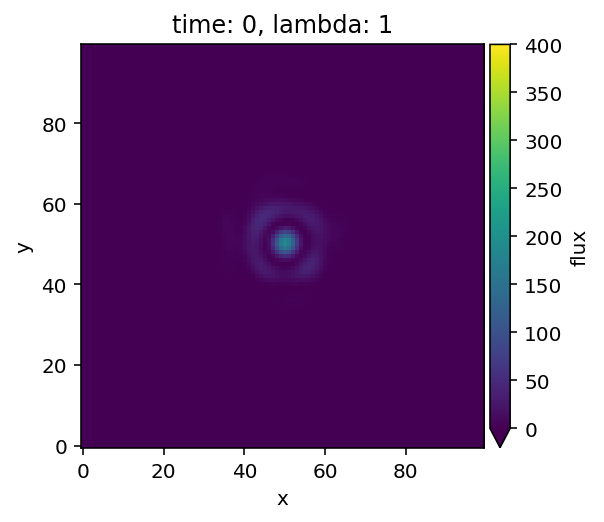
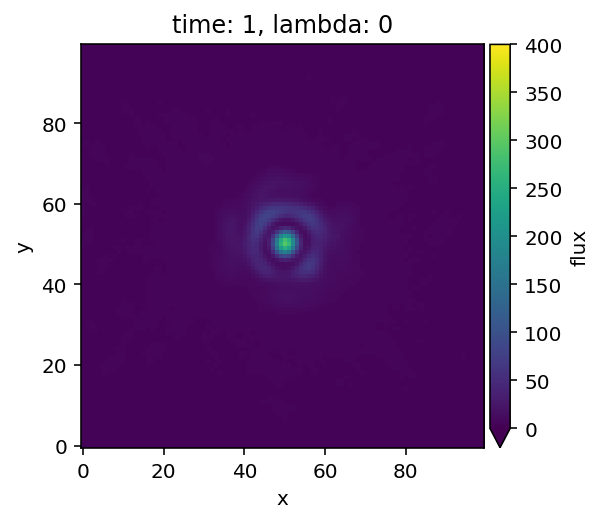
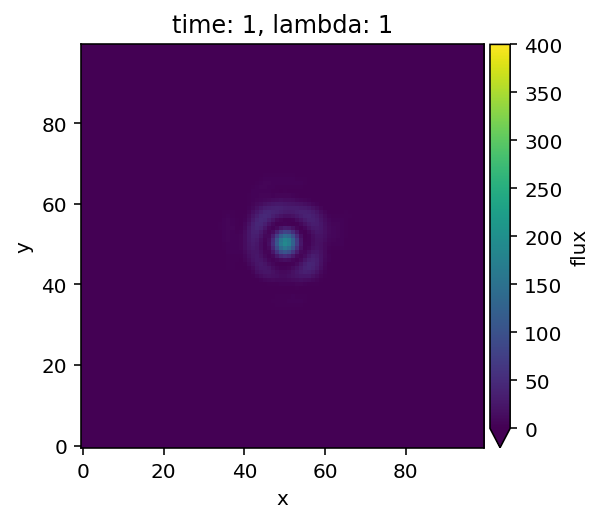
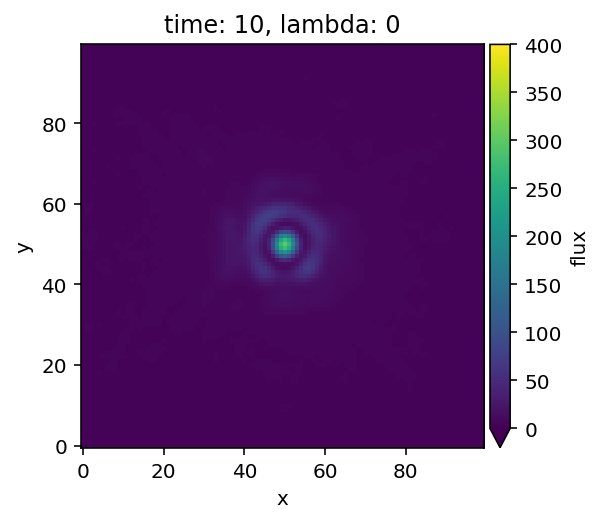
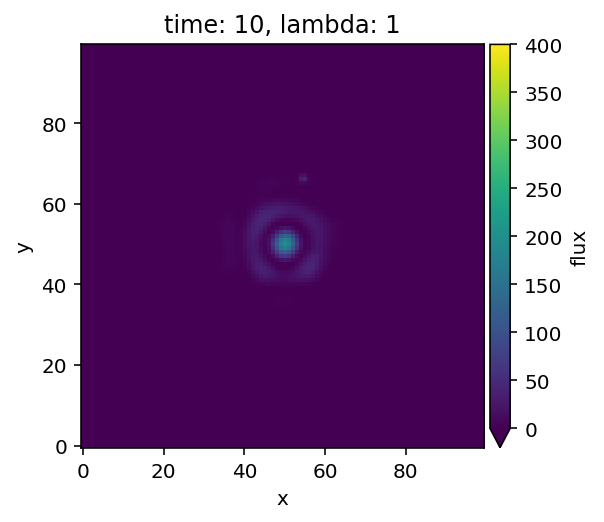
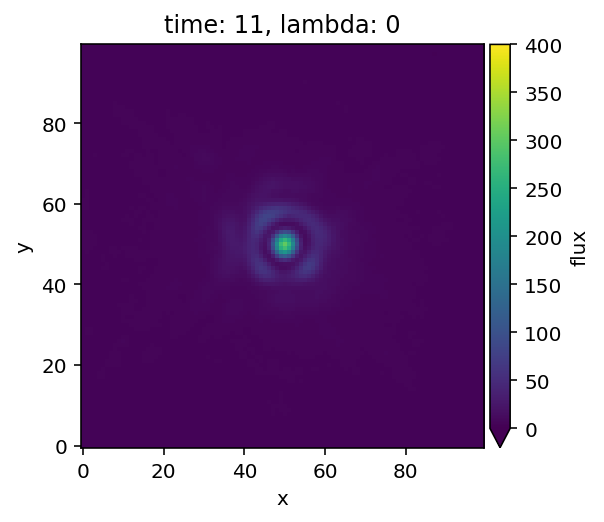
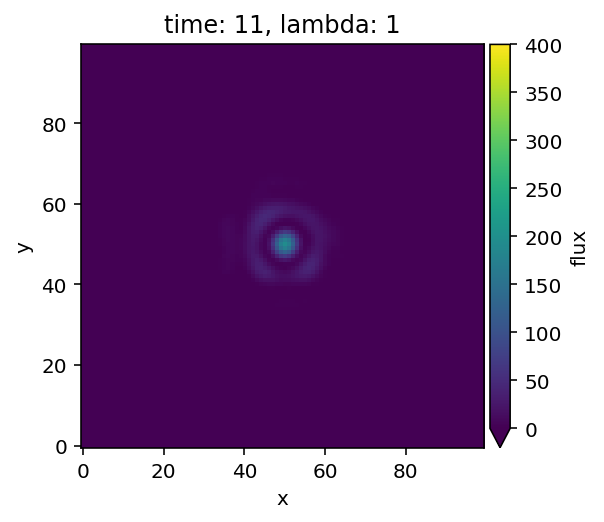
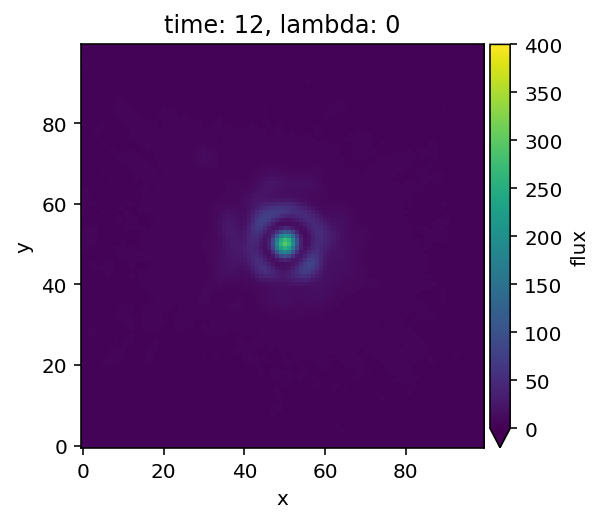
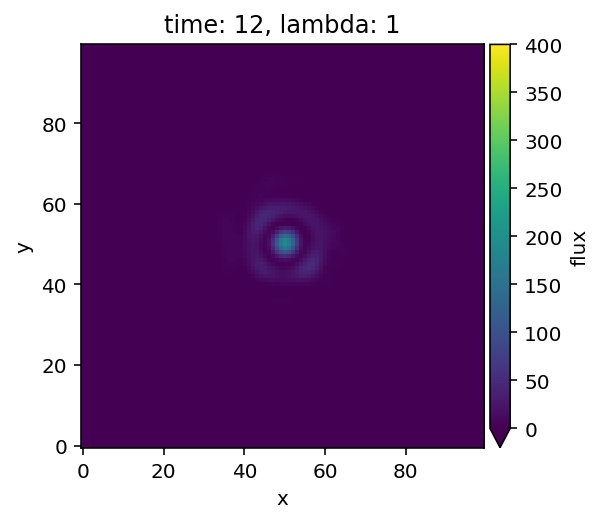
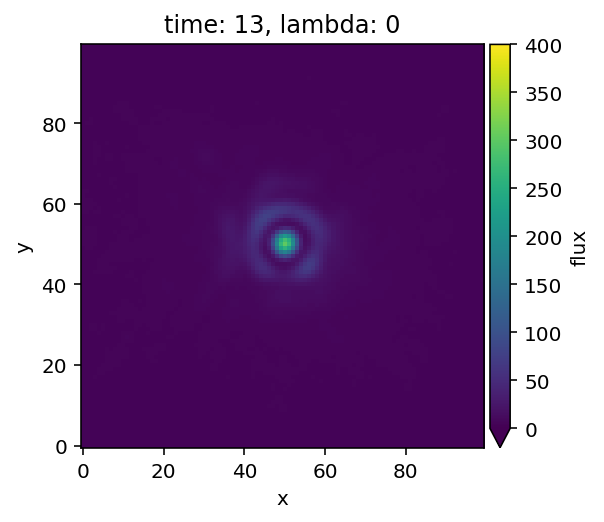
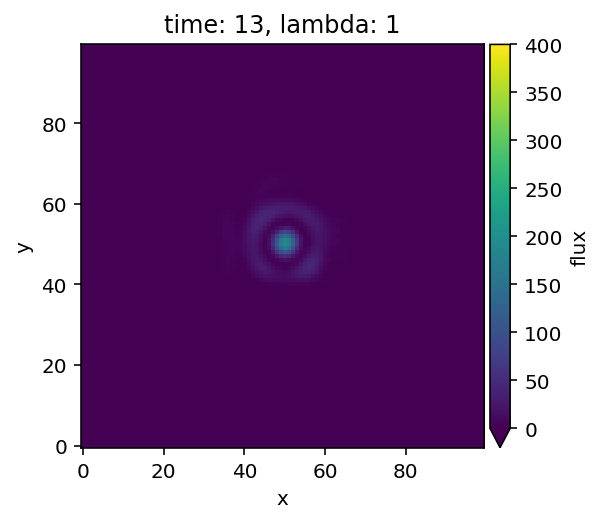
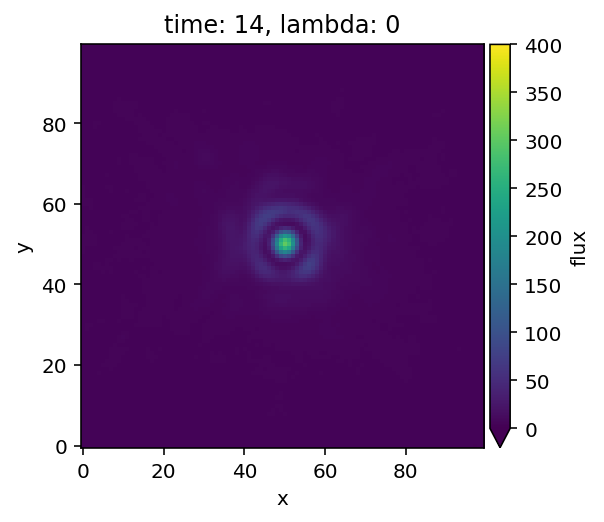
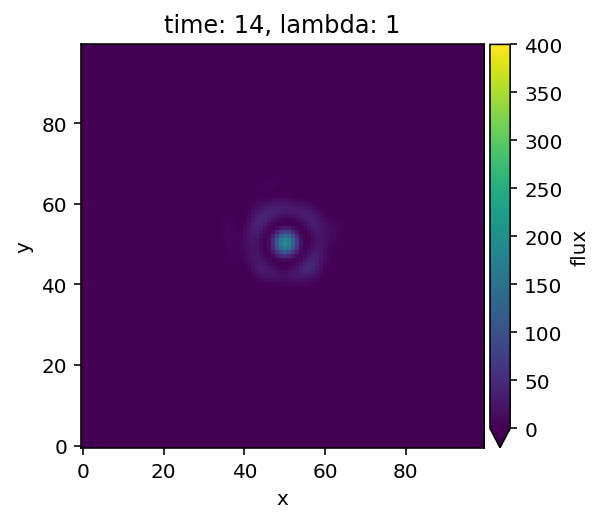
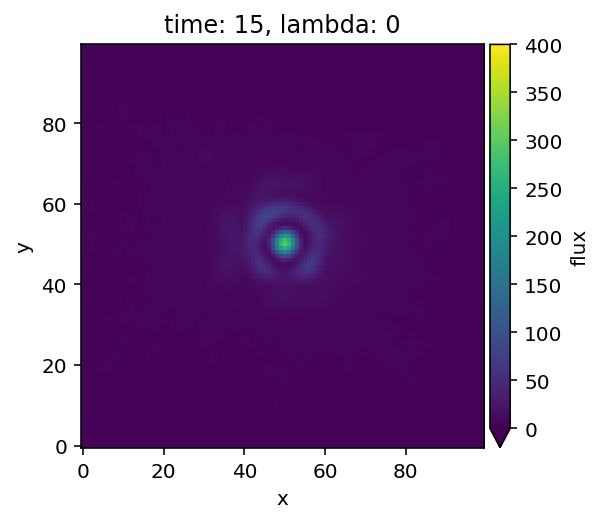
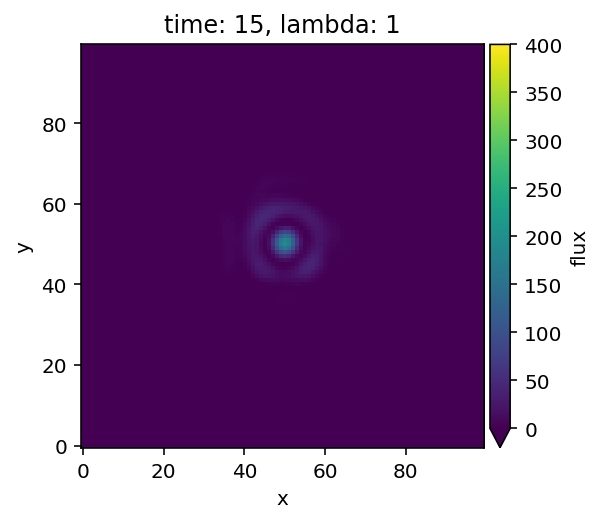
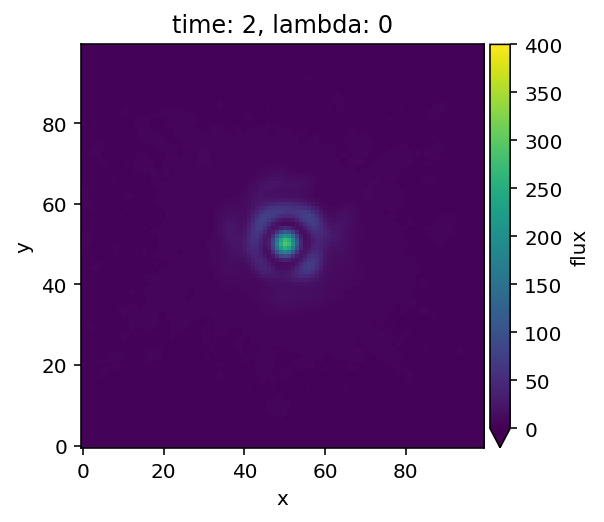
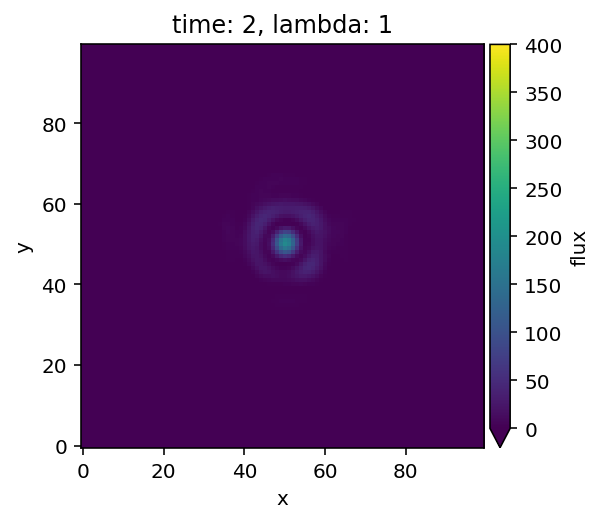
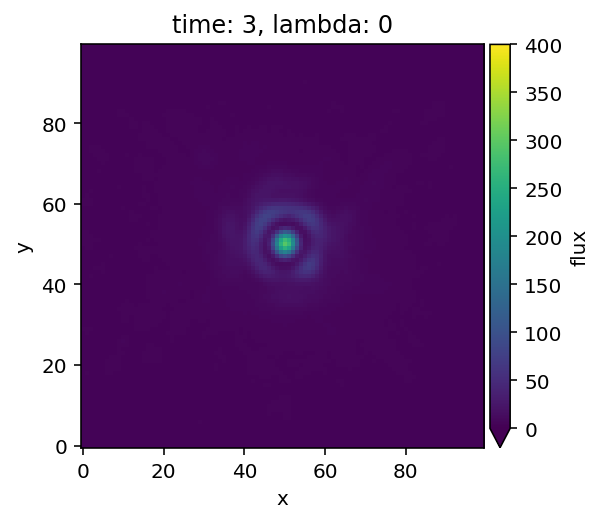
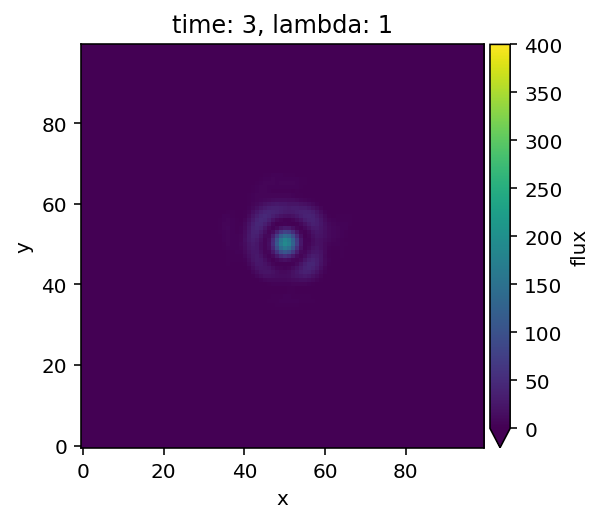
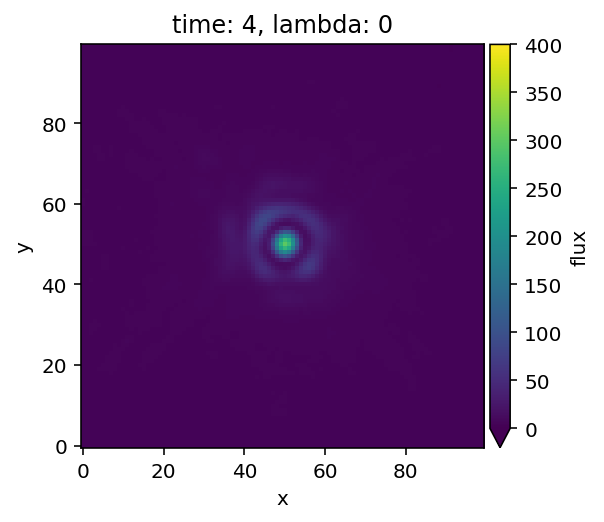
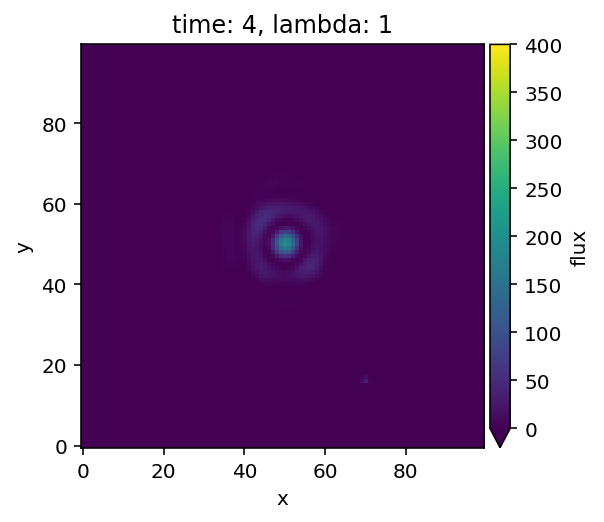
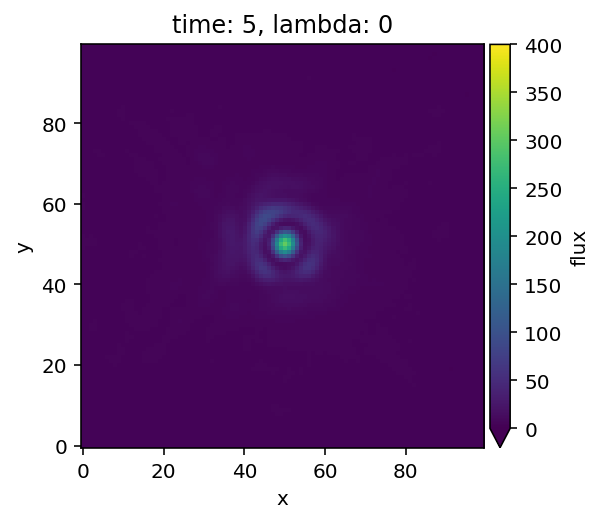
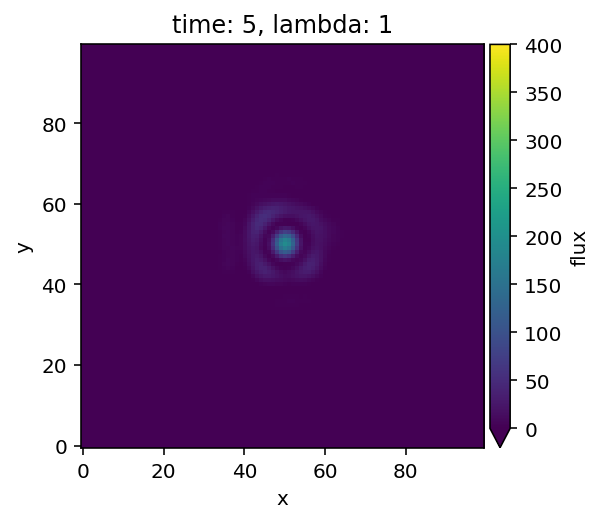
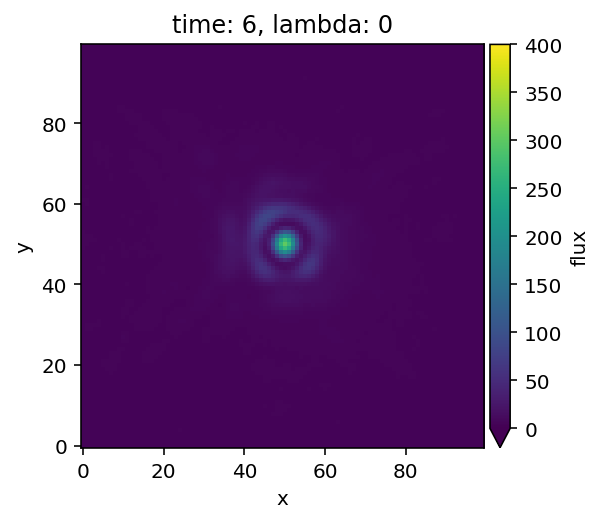
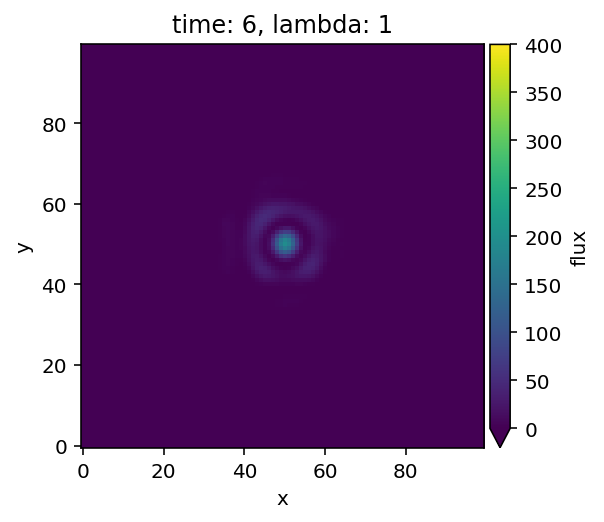
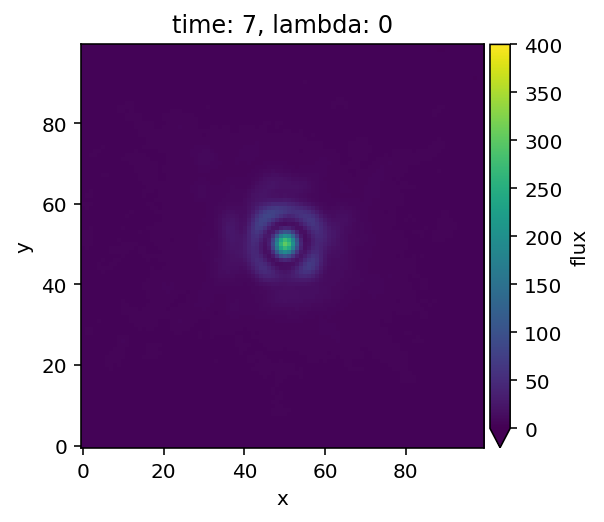
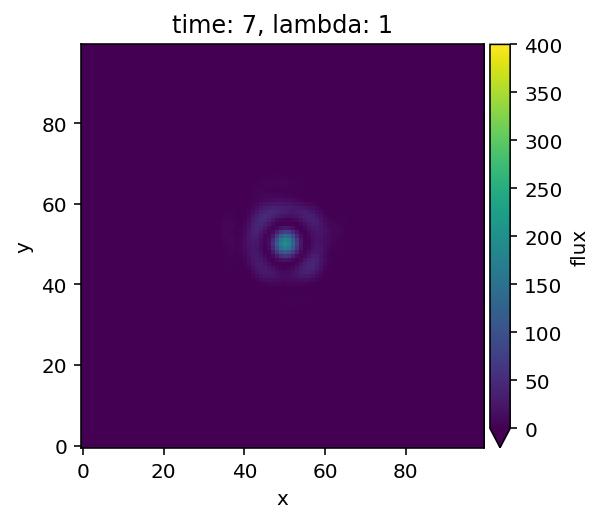
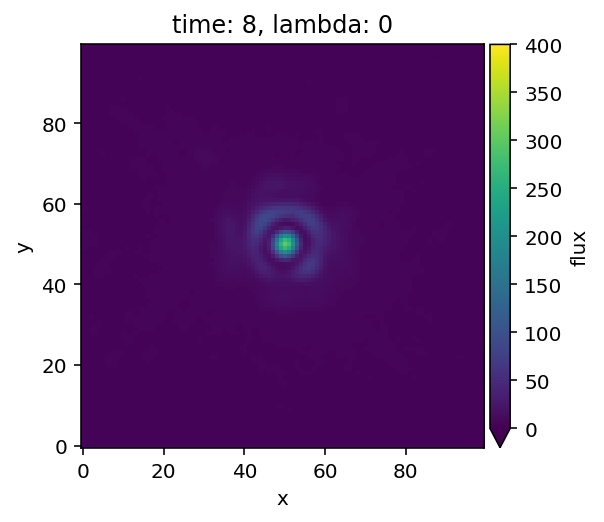
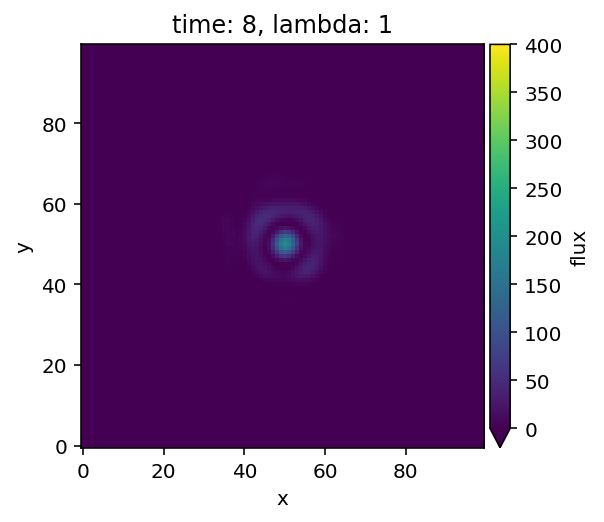
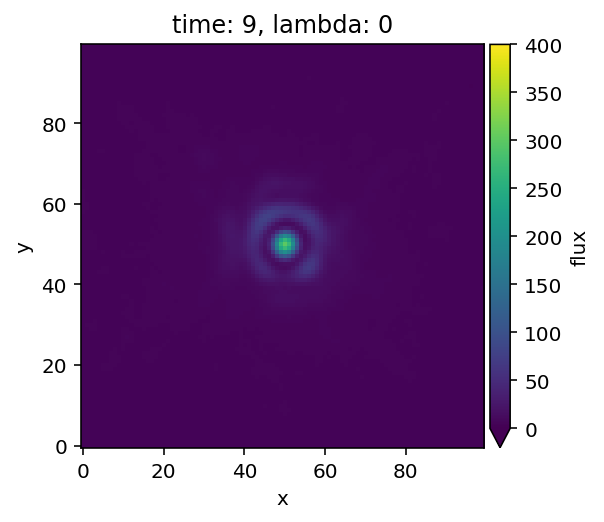
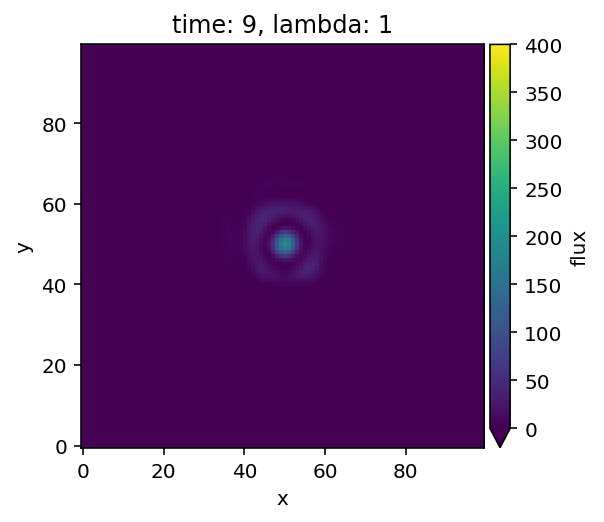
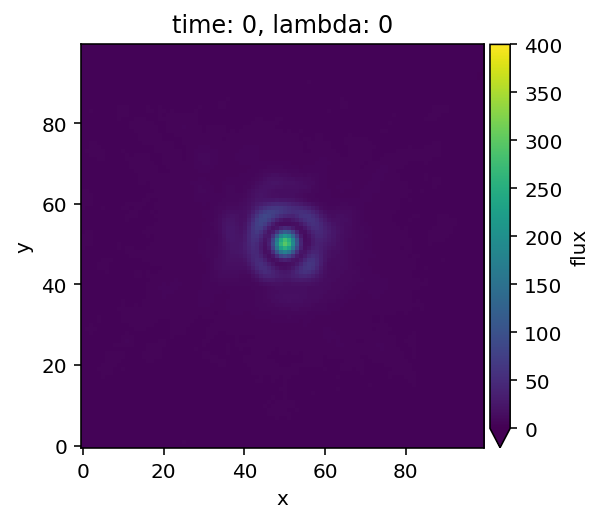

In [6]:
# Let's visualize the cube of the reference star
plot_cubes(cube_crop_frames(cube_ref,100), dynamic=False, vmin=0, vmax=400)

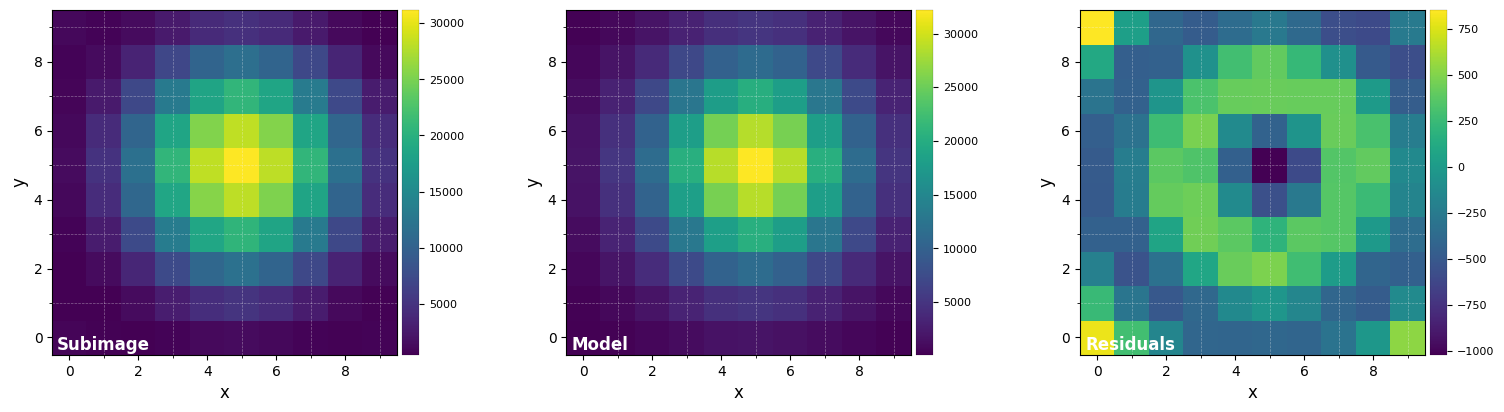

FWHM_y = 4.884118657343279
FWHM_x = 4.928131772465463 

centroid y = 31.994525422536512
centroid x = 31.997769096236357
centroid y subim = 4.994525422536511
centroid x subim = 4.997769096236357 

amplitude = 32215.114215810892
theta = 34.24397630801609


In [8]:
# Let’s measure the Full-Width Half-Maximum (FWHM) by fitting a 2D Gaussian to the core of the unsaturated non-coronagraphic PSF.
%matplotlib inline
DF_fit_K1 = fit_2dgaussian(psf[0,0,:,:], crop=True, cropsize=10, debug=True, full_output=True)

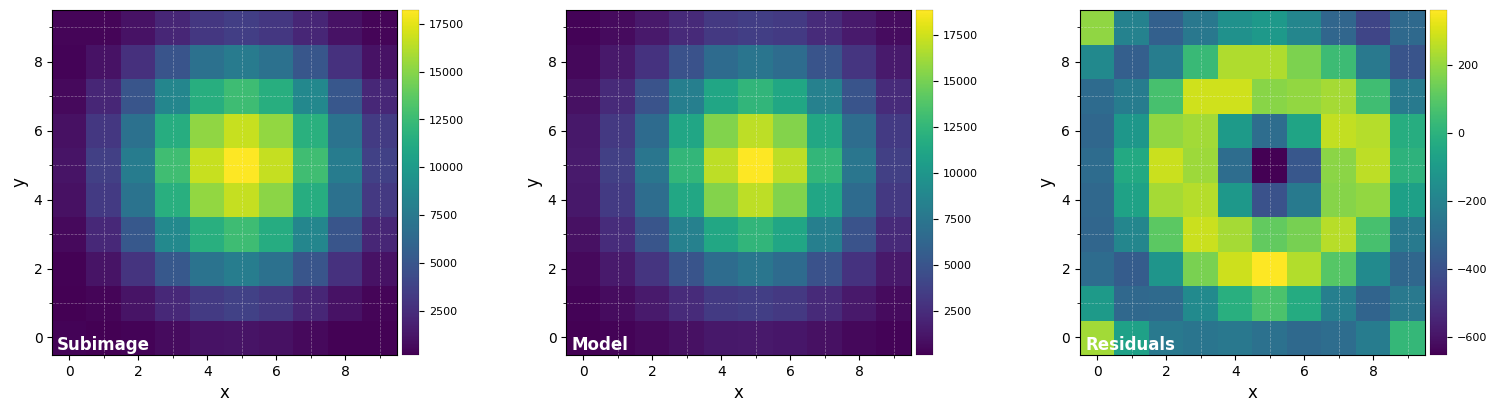

FWHM_y = 5.21959816319713
FWHM_x = 5.15721150864012 

centroid y = 31.998325152713313
centroid x = 32.000014333523886
centroid y subim = 4.998325152713312
centroid x subim = 5.000014333523883 

amplitude = 18878.424226295494
theta = 127.9141947699384


In [9]:
DF_fit_K2 = fit_2dgaussian(psf[1,0,:,:], crop=True, cropsize=10, debug=True, full_output=True)

In [10]:
fwhm_sphere_K1 = np.mean([DF_fit_K1['fwhm_x'], DF_fit_K1['fwhm_y']])
print(fwhm_sphere_K1)

4.906125214904371


In [11]:
fwhm_sphere_K2 = np.mean([DF_fit_K2['fwhm_x'], DF_fit_K2['fwhm_y']])
print(fwhm_sphere_K2)

5.188404835918625


In [12]:
# Let's normalize the flux to one in a 1xFWHM aperture and crop the PSF array
psfn_K1 = normalize_psf(psf[0,0,:,:], fwhm_sphere_K1, size=19, imlib='ndimage-fourier')

Flux in 1xFWHM aperture: 434925.766


In [13]:
psfn_K2 = normalize_psf(psf[1,0,:,:], fwhm_sphere_K2, size=19, imlib='ndimage-fourier')

Flux in 1xFWHM aperture: 286453.261


## Pre-processing

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-11-27 20:30:42
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
2d gauss-fitting
Running time:  0:00:09.752407
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


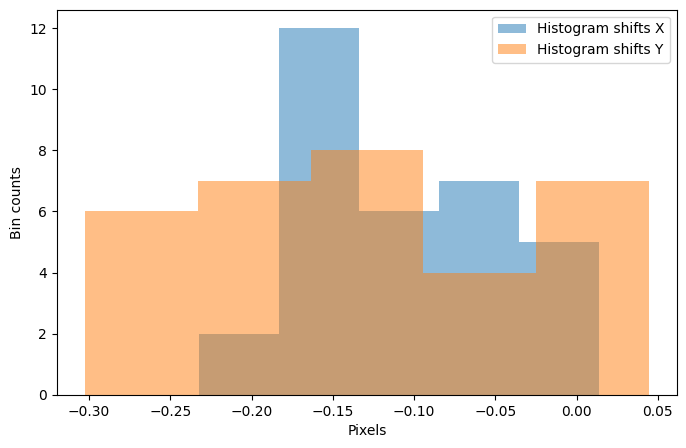

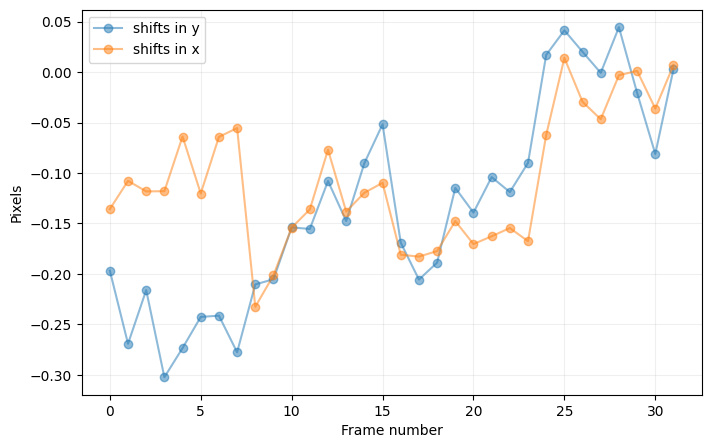

In [14]:
cube_K1, shy_K1, shx_K1 = cube_recenter_2dfit(cube[0,:,:,:], xy=(512, 512), fwhm=fwhm_sphere_K1, nproc=1, subi_size=6,
                                        model='gauss', negative=False, full_output=True, debug=False,
                                        imlib='vip-fft')

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-11-27 20:30:52
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
2d gauss-fitting
Running time:  0:00:04.120690
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


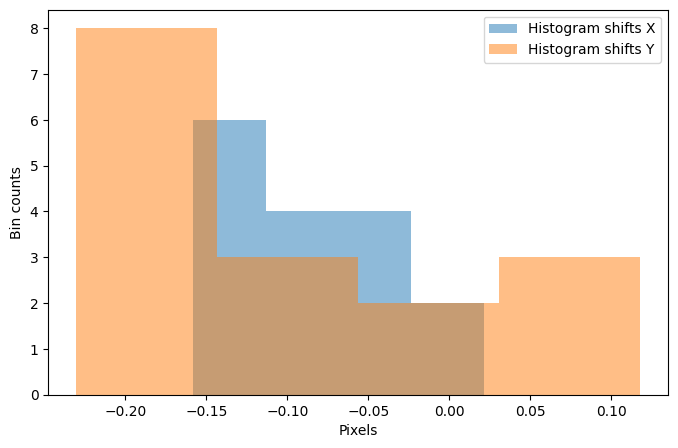

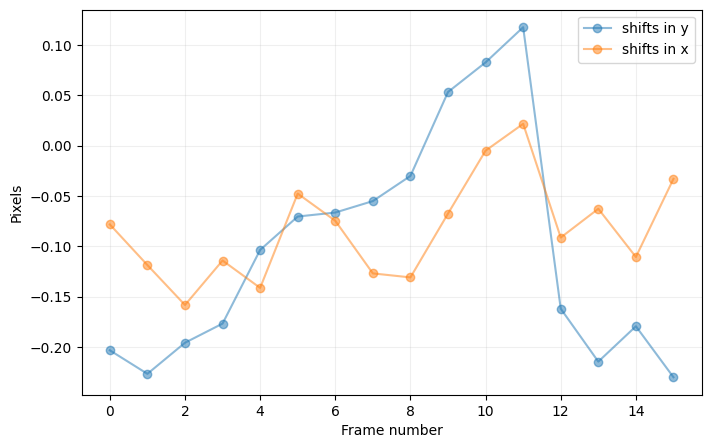

In [15]:
cube_ref_K1, shy_ref_K1, shx_ref_K1 = cube_recenter_2dfit(cube_ref[0,:,:,:], xy=(512, 512), fwhm=fwhm_sphere_K1, nproc=1, subi_size=6,
                                        model='gauss', negative=False, full_output=True, debug=False,
                                        imlib='vip-fft')

New shape: (10, 10)
New shape: (10, 10)


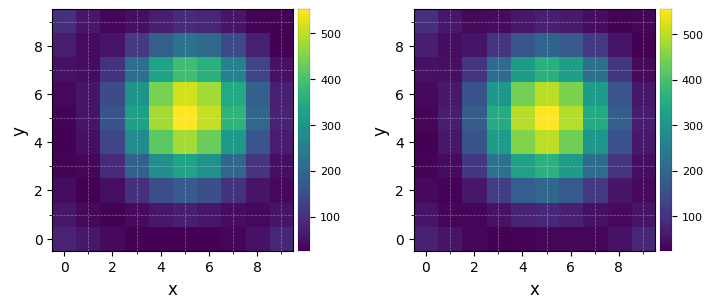

In [16]:
plot_frames((frame_crop(cube[0,0,:,:], 10),frame_crop(cube_K1[0], 10)), grid=True, size_factor=4)

New shape: (10, 10)
New shape: (10, 10)


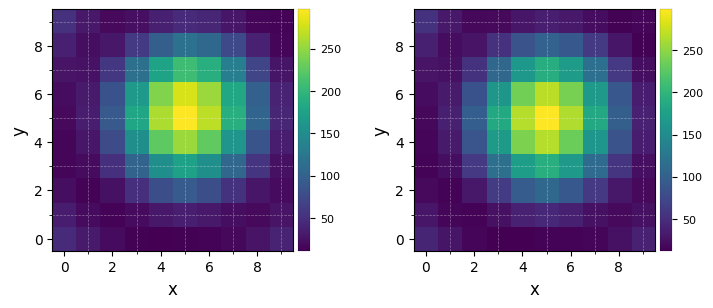

In [17]:
plot_frames((frame_crop(cube_ref[0,0,:,:], 10),frame_crop(cube_ref_K1[0], 10)), grid=True, size_factor=4)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-11-27 20:31:01
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
2d gauss-fitting
Running time:  0:00:11.442214
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


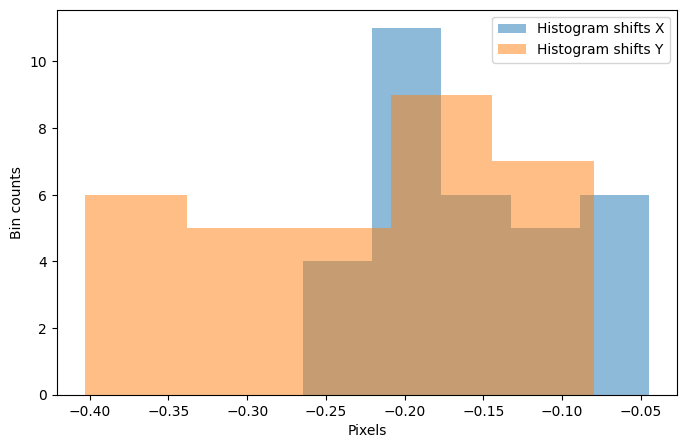

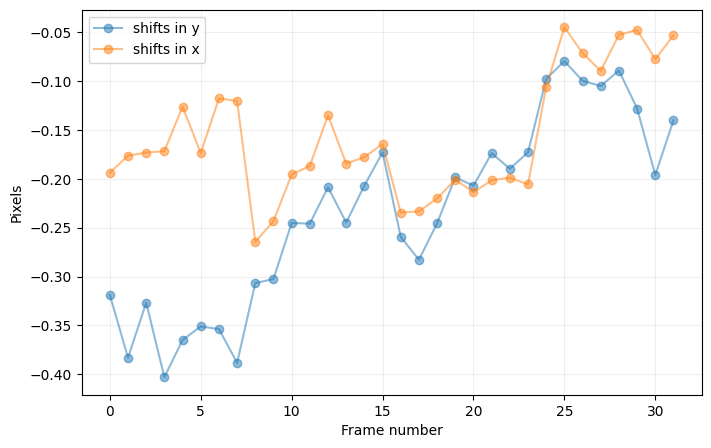

In [18]:
cube_K2, shy_K2, shx_K2 = cube_recenter_2dfit(cube[1,:,:,:], xy=(512, 512), fwhm=fwhm_sphere_K2, nproc=1, subi_size=6,
                                        model='gauss', negative=False, full_output=True, debug=False,
                                        imlib='vip-fft')

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-11-27 20:31:13
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
2d gauss-fitting
Running time:  0:00:05.420641
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


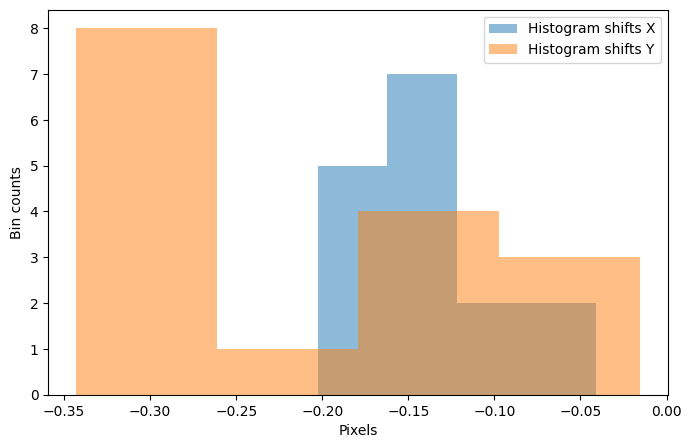

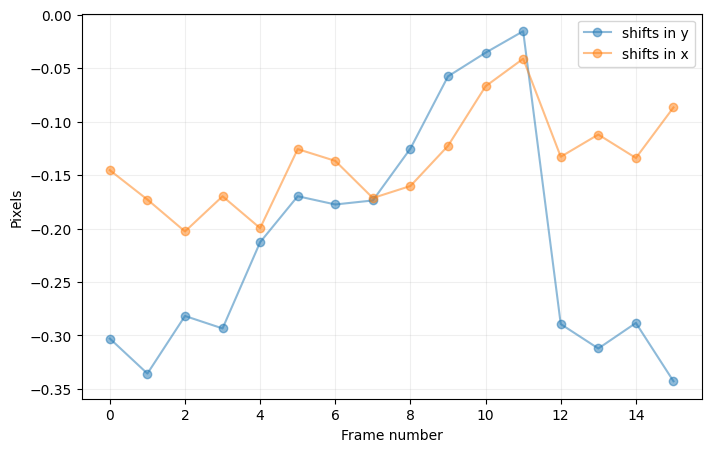

In [19]:
cube_ref_K2, shy_ref_K2, shx_ref_K2 = cube_recenter_2dfit(cube_ref[1,:,:,:], xy=(512, 512), fwhm=fwhm_sphere_K2, nproc=1, subi_size=6,
                                        model='gauss', negative=False, full_output=True, debug=False,
                                        imlib='vip-fft')

New shape: (10, 10)
New shape: (10, 10)


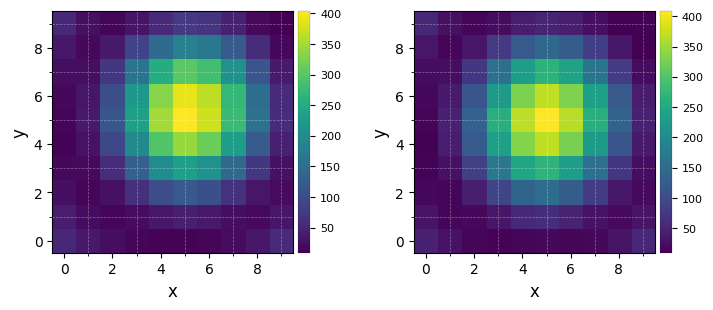

In [20]:
plot_frames((frame_crop(cube[1,0,:,:], 10),frame_crop(cube_K2[0], 10)), grid=True, size_factor=4)

New shape: (10, 10)
New shape: (10, 10)


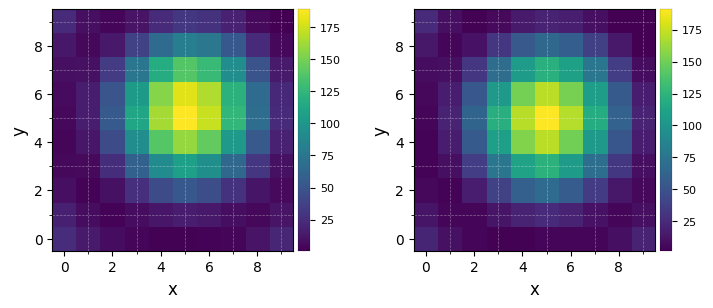

In [21]:
plot_frames((frame_crop(cube_ref[1,0,:,:], 10),frame_crop(cube_ref_K2[0], 10)), grid=True, size_factor=4)

## Model PSF subtraction for RDI

In [56]:
# We set the preferred method to be used for image rotation.
imlib = 'vip-fft'
interpolation=None

In [63]:
fr_pca_K1 = pca(cube_K1, angle, cube_ref=cube_ref_K1, ncomp=10, mask_center_px=None, imlib=imlib, interpolation=interpolation,
              svd_mode='lapack')

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-11-27 20:50:18
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 134.824 GB
System available memory = 103.627 GB
Done vectorizing the frames. Matrix shape: (32, 1048576)
Done vectorizing the frames. Matrix shape: (16, 1048576)
Done SVD/PCA with numpy SVD (LAPACK)
Done de-rotating and combining
Running time:  0:09:23.607802
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [64]:
fr_pca_K2 = pca(cube_K2, angle, cube_ref=cube_ref_K2, ncomp=10, mask_center_px=None, imlib=imlib, interpolation=interpolation,
              svd_mode='lapack')

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-11-27 20:59:42
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 134.824 GB
System available memory = 102.241 GB
Done vectorizing the frames. Matrix shape: (32, 1048576)
Done vectorizing the frames. Matrix shape: (16, 1048576)
Done SVD/PCA with numpy SVD (LAPACK)


Done de-rotating and combining
Running time:  0:09:27.474704
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


New shape: (210, 210)


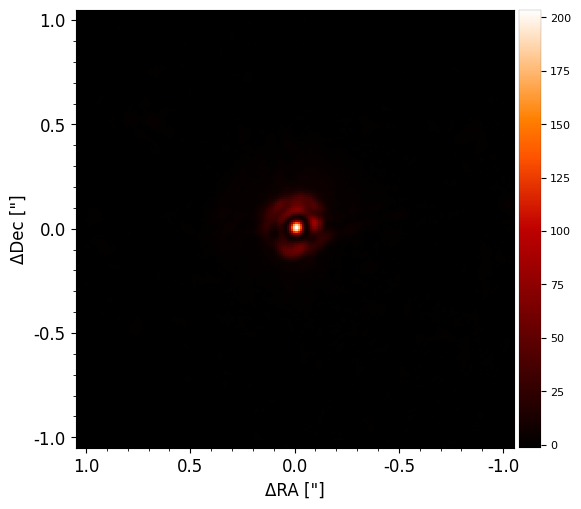

In [65]:
plot_frames((frame_crop(fr_pca_K1, 210)), backend='matplotlib', ang_scale=True, cmap = 'gist_heat')

New shape: (210, 210)


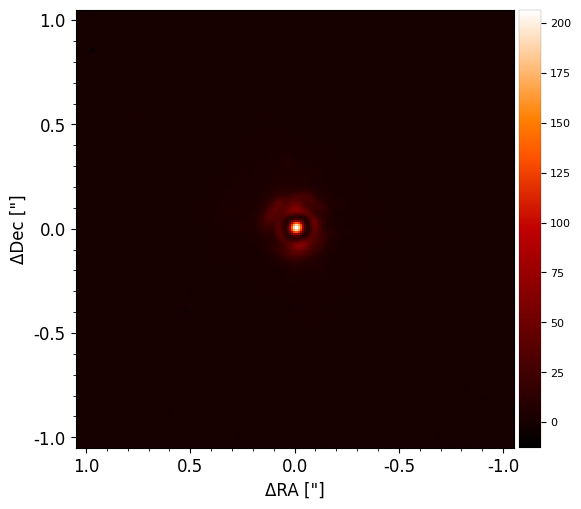

In [66]:
plot_frames((frame_crop(fr_pca_K2, 210)), backend='matplotlib', ang_scale=True, cmap = 'gist_heat')

In [67]:
# Let's save the resulting arrays
#np.savetxt('HD143006_fr_pca_K1_RDI_2023-07-02', fr_pca_K1)
#np.savetxt('HD143006_fr_pca_K2_RDI_2023-07-02', fr_pca_K2)

In [68]:
from numpy import loadtxt

fr_pca_K1 = loadtxt('HD143006_fr_pca_K1_RDI_2023-07-02')
fr_pca_K2 = loadtxt('HD143006_fr_pca_K2_RDI_2023-07-02')

## Plotting the disk structures 

In [69]:
from astropy.visualization import (AsinhStretch, LinearStretch, LogStretch, ImageNormalize)
from matplotlib.patches import Ellipse
import matplotlib.gridspec as gridspec
import scipy.ndimage
from matplotlib.offsetbox import AnchoredOffsetbox, AuxTransformBox, DrawingArea, TextArea, VPacker
from matplotlib.patches import Rectangle

In [85]:
fig = plt.figure(figsize=(10, 9))
gs  = gridspec.GridSpec(2, 2, figure = fig, width_ratios=(1, 1), height_ratios=(1, 1))
norm = ImageNormalize(vmin=-5,vmax=5, stretch=LinearStretch())
fig_size = 1.2

<Figure size 1000x900 with 0 Axes>

In [86]:
aoff, doff = 0,0 #-0.89,0.9
RA_CO  = -12.25e-3 * (np.arange(cubee[0].header['NAXIS1'])-(512.512))
DEC_CO = 12.25e-3 * (np.arange(cubee[0].header['NAXIS2'])-(512.512))
ext_CO = (np.max(RA_CO)-aoff, np.min(RA_CO)-aoff, np.min(DEC_CO)-doff, np.max(DEC_CO)-doff)

In [87]:
def mk_ellipse(x0,y0,R,incl,PA, npts=200):
    phi = 2.*np.pi*np.arange(npts)/(npts-1.)
    incl_rad = incl * np.pi/180.
    PA_rad = (PA) * np.pi/180.
    xell = R*np.cos(phi)*np.cos(incl_rad)
    yell = R*np.sin(phi)
    xrot = ( (xell)*np.cos(PA_rad) + (yell)*np.sin(PA_rad) ) + x0
    yrot = (-(xell)*np.sin(PA_rad) + (yell)*np.cos(PA_rad) ) + y0
    return [xrot, yrot]

In [88]:
#gap radius, offsets,inclination and position angle
g1 = 133e-3
x0g1, y0g1 = -5.9e-3, 21.7e-3
ig1 = 18.6
PAg1 = 169

g2 = 309e-3
x0g2, y0g2 = -5.9e-3, 21.7e-3
ig2 = 18.6
PAg2 = 169

#ring radius, offsets,inclination and position angle
r1 = 247.3e-3
x0r1, y0r1 = -6.3e-3, 21.5e-3 # consider this as outer disk offsets
ir1 = 18.9
PAr1 = 169

r2 = 393e-3
x0r2, y0r2 = -1.4e-3, 24e-3 # consider this as outer disk offsets
ir2 = 17.2
PAr2 = 164

In [89]:
#gap ellipse
xg1, yg1 = mk_ellipse(x0g1,y0g1,g1,ig1,PAg1,5000)
xg2, yg2 = mk_ellipse(x0g2,y0g2,g2,ig2,PAg2,5000)
xr1, yr1 = mk_ellipse(x0r1,y0r1,r1,ir1,PAr1,500)
xr2, yr2 = mk_ellipse(x0r2,y0r2,r2,ir2,PAr2,500)

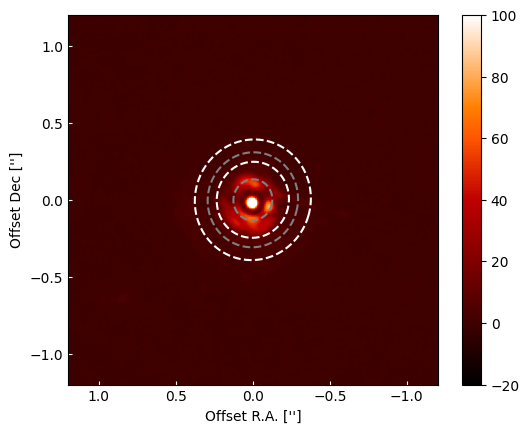

In [90]:
ax1 = fig.add_subplot(gs[0,0])
masked_array = np.ma.array(fr_pca_K1, mask=np.isnan(fr_pca_K1))
im1 = plt.imshow(masked_array, extent=ext_CO, cmap = 'gist_heat', vmax=100, vmin=-20)
plt.xlim([fig_size,-fig_size])
plt.ylim([-fig_size,fig_size])
plt.xlabel("Offset R.A. ['']")
plt.ylabel("Offset Dec ['']")
plt.tick_params('both', length=3, direction='in', which='major', color='white',labelcolor='k')
#plt.title('AS209 (band K1)', fontsize='x-large')
#plt.yticks([-1.0,- 0.5, 0.0, 0.5, 1.0])
#plt.xticks([1.5, 1.0, 0.5, 0.0, -0.5, -1.0, -1.5])
plt.plot(xr1-x0r1,yr1-y0r1,'w--')
plt.plot(xg1-x0g1,yg1-y0g1,'--', color='0.5')
plt.plot(xr2-x0r2,yr2-y0r2,'w--')
plt.plot(xg2-x0g2,yg2-y0g2,'--', color='0.5')
plt.colorbar()
plt.show()

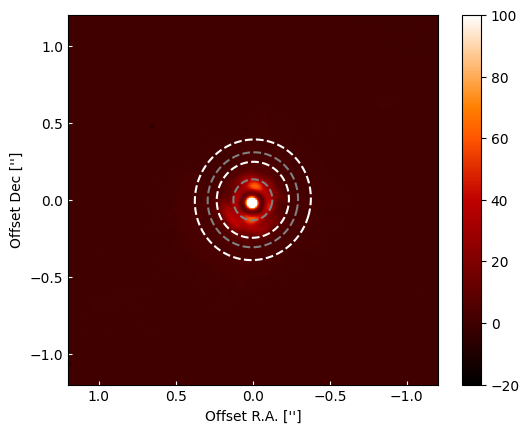

In [91]:
ax2 = fig.add_subplot(gs[0,0])
masked_array2 = np.ma.array(fr_pca_K2, mask=np.isnan(fr_pca_K2))
im2 = plt.imshow(masked_array2, extent=ext_CO, cmap = 'gist_heat', vmax=100, vmin=-20)
plt.xlim([fig_size,-fig_size])
plt.ylim([-fig_size,fig_size])
plt.xlabel("Offset R.A. ['']")
plt.ylabel("Offset Dec ['']")
plt.tick_params('both', length=3, direction='in', which='major', color='white',labelcolor='k')
#plt.title('AS209 (band K1)', fontsize='x-large')
#plt.yticks([-1.0,- 0.5, 0.0, 0.5, 1.0])
#plt.xticks([1.5, 1.0, 0.5, 0.0, -0.5, -1.0, -1.5])
plt.plot(xr1-x0r1,yr1-y0r1,'w--')
plt.plot(xg1-x0g1,yg1-y0g1,'--', color='0.5')
plt.plot(xr2-x0r2,yr2-y0r2,'w--')
plt.plot(xg2-x0g2,yg2-y0g2,'--', color='0.5')
plt.colorbar()
plt.show()